In [1]:
%matplotlib inline

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import histlite as hl
import csky as cy
import os

import matplotlib as mpl
from matplotlib.lines import Line2D
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots_nb.mplstyle')
#palette = sns.color_palette('Dark2')
palette = sns.color_palette('Paired')

In [3]:
timer = cy.timing.Timer()
time = timer.time

## Begin with GFU (offline processing, v02_p05)

In [4]:
sinDecs = np.r_[-0.95:0.95:20j]
inj_gamma = [2.0, 2.5, 3.0]

if os.path.exists('/data/user/apizzuto/fast_response_skylab/offline_vs_online_gfu/dump/gfu_offline_sens_100tev.pkl'):
    with open('./dump/gfu_offline_sens_100tev.pkl', 'rb') as f:
        all_gamma_results = pickle.load(f)
else:
    ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/')
    with time('ana setup'):
        ana = cy.get_analysis(
            cy.selections.repo,
            'version-002-p05', cy.selections.GFUDataSpecs.GFU_IC86,
            dir=ana_dir)

    cy.CONF['ana'] = ana
    cy.CONF['mp_cpus'] = 10
    all_gamma_results = dict()

    for gamma in inj_gamma:
        results = dict(sens_n = [],
                      sens_e2dnde = [],
                      disc_n = [],
                      disc_e2dnde = [],
                      sindec = [])

        for sd in sinDecs:
            print(f"\nWorking on source at sindec {sd}")

            src = cy.sources(0.0, np.arcsin(sd))
            cy.CONF['src'] = src
            tr = cy.get_trial_runner(flux=cy.hyp.PowerLawFlux(gamma=gamma))
            bg = cy.dists.Chi2TSD(tr.get_many_fits(1000, seed=1))
            sens = tr.find_n_sig(
                # ts, threshold
                bg.median(),
                # beta, fraction of trials which should exceed the threshold
                0.9,
                # n_inj step size for initial scan
                n_sig_step=5,
                # this many trials at a time
                batch_size=100,
                # tolerance, as estimated relative error
                tol=.05
            )

            disc = tr.find_n_sig(bg.isf_nsigma(5), 0.5, n_sig_step=5, batch_size=100, tol=.05)
            results['sens_n'].append(sens['n_sig'])
            results['disc_n'].append(disc['n_sig'])
            results['sens_e2dnde'].append(tr.to_E2dNdE(sens, E0=100, unit=1e3))
            results['disc_e2dnde'].append(tr.to_E2dNdE(disc['n_sig'], E0=100, unit=1e3))
            results['sindec'].append(sd)
        all_gamma_results[gamma] = results

In [5]:
def conv_ref_en(fl, e1, e0, gamma):
    return np.asarray(fl) * (e1/e0)**(2.-gamma)

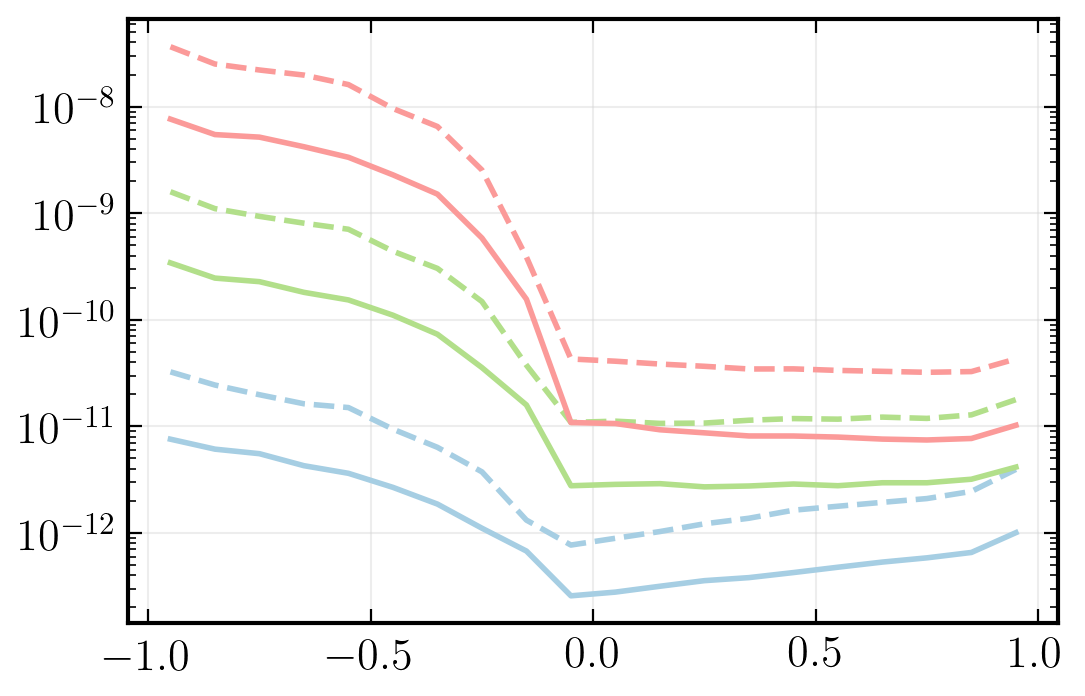

In [6]:
fig = plt.figure(dpi=200)
for ii, gamma in enumerate(inj_gamma):
    one_tev_sens = conv_ref_en(all_gamma_results[gamma]['sens_e2dnde'], 1., 100., gamma)
    one_tev_disc = conv_ref_en(all_gamma_results[gamma]['disc_e2dnde'], 1., 100., gamma)
    plt.plot(all_gamma_results[gamma]['sindec'], one_tev_sens,
            color=palette[2*ii], lw=2., ls='-')
    plt.plot(all_gamma_results[gamma]['sindec'], one_tev_disc,
            color=palette[2*ii], lw=2., ls='--')
    
plt.yscale('log')

In [54]:
import pickle

In [57]:
with open('./dump/gfu_offline_sens_100tev.pkl', 'wb') as f:
    pickle.dump(all_gamma_results, f)

## GFUOnline now
For GFUOnline, we don't have a selections object, so first we write one of our own

In [7]:
sinDecs = np.r_[-0.95:0.95:20j]
inj_gamma = [2.0, 2.5, 3.0]

if os.path.exists('/data/user/apizzuto/fast_response_skylab/offline_vs_online_gfu/dump/gfu_online_sens_100tev.pkl'):
    with open('./dump/gfu_online_sens_100tev.pkl', 'rb') as f:
        all_gamma_results_online = pickle.load(f)
else:
    class GFUOnlineDataSpecs(object):
        class GFUOnlineDataSpec(cy.selections.TrackSpec):
            _bins_sindec = np.unique(np.concatenate([
                 np.linspace(-1, -0.93, 4 + 1),
                 np.linspace(-0.93, -0.3, 10 + 1),
                 np.linspace(-0.3, 0.05, 9 + 1),
                 np.linspace(0.05, 1, 18 + 1) ]))
            _bins_logenergy = np.arange(1, 9.5 + 0.01, 0.125)
            def dataset_modifications(self, ds):
                max_sigma = np.radians(15)
                ds.data = ds.data[ds.data.sigma < max_sigma]
                ds.sig = ds.sig[ds.sig.sigma < max_sigma]
                #ds.data.sigma = np.minimum(ds.data.sigma, max_sigma)
                #ds.sig.sigma = np.minimum(ds.sig.sigma, max_sigma)

        class GFUOnline_IC86 (GFUOnlineDataSpec):
            _path_sig = 'gfu_online/{version}/IC86_2011_MC.npy'
            _path_data = ['gfu_online/{{version}}/IC86_201{}_data.npy'.format(i) for i in range(1,9)]
            _path_grls = ['gfu_online/{{version}}/GRL/IC86_201{}_data.npy'.format(i) for i in range(1,9)]
            def __init__(self, years=list(map(str, 2010 + np.arange(1, 9)))):
                self.path_data = ['gfu_online/{{version}}/IC86_{}_data.npy'.format(y) for y in years]
                self.path_grls = ['gfu_online/{{version}}/GRL/IC86_{}_data.npy'.format(y) for y in years]
                self._key = 'GFUOnline_for_' + '_'.join(years)

        gfuonline_IC86 = [GFUOnline_IC86]

    ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/')
    with time('ana setup'):
        ana = cy.analysis.Analysis(cy.selections.repo, [GFUOnlineDataSpecs.GFUOnline_IC86])

    cy.CONF['ana'] = ana
    cy.CONF['mp_cpus'] = 10

    all_gamma_results_online = dict()

    for gamma in inj_gamma:
        results = dict(sens_n = [],
                      sens_e2dnde = [],
                      disc_n = [],
                      disc_e2dnde = [],
                      sindec = [])

        for sd in sinDecs:
            print(f"\nWorking on source at sindec {sd}")

            src = cy.sources(0.0, np.arcsin(sd))
            cy.CONF['src'] = src
            tr = cy.get_trial_runner(flux=cy.hyp.PowerLawFlux(gamma=gamma))
            bg = cy.dists.Chi2TSD(tr.get_many_fits(1000, seed=1))
            sens = tr.find_n_sig(
                # ts, threshold
                bg.median(),
                # beta, fraction of trials which should exceed the threshold
                0.9,
                # n_inj step size for initial scan
                n_sig_step=5,
                # this many trials at a time
                batch_size=100,
                # tolerance, as estimated relative error
                tol=.05
            )

            disc = tr.find_n_sig(bg.isf_nsigma(5), 0.5, n_sig_step=5, batch_size=100, tol=.05)
            results['sens_n'].append(sens['n_sig'])
            results['disc_n'].append(disc['n_sig'])
            results['sens_e2dnde'].append(tr.to_E2dNdE(sens, E0=100, unit=1e3))
            results['disc_e2dnde'].append(tr.to_E2dNdE(disc['n_sig'], E0=100, unit=1e3))
            results['sindec'].append(sd)
        all_gamma_results_online[gamma] = results

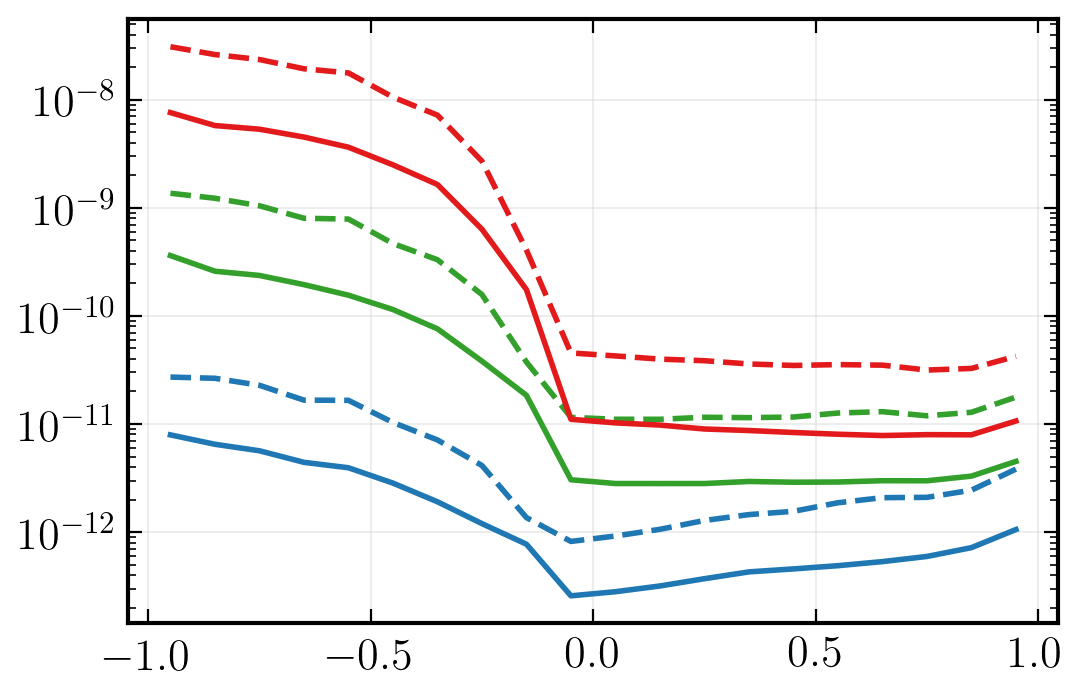

In [8]:
fig = plt.figure(dpi=200)
for ii, gamma in enumerate(inj_gamma):
    one_tev_sens = conv_ref_en(all_gamma_results_online[gamma]['sens_e2dnde'], 1., 100., gamma)
    one_tev_disc = conv_ref_en(all_gamma_results_online[gamma]['disc_e2dnde'], 1., 100., gamma)
    plt.plot(all_gamma_results_online[gamma]['sindec'], one_tev_sens,
            color=palette[2*ii+1], lw=2., ls='-')
    plt.plot(all_gamma_results_online[gamma]['sindec'], one_tev_disc,
            color=palette[2*ii+1], lw=2., ls='--')
    
plt.yscale('log')

In [87]:
with open('./dump/gfu_online_sens_100tev.pkl', 'wb') as f:
    pickle.dump(all_gamma_results_online, f)

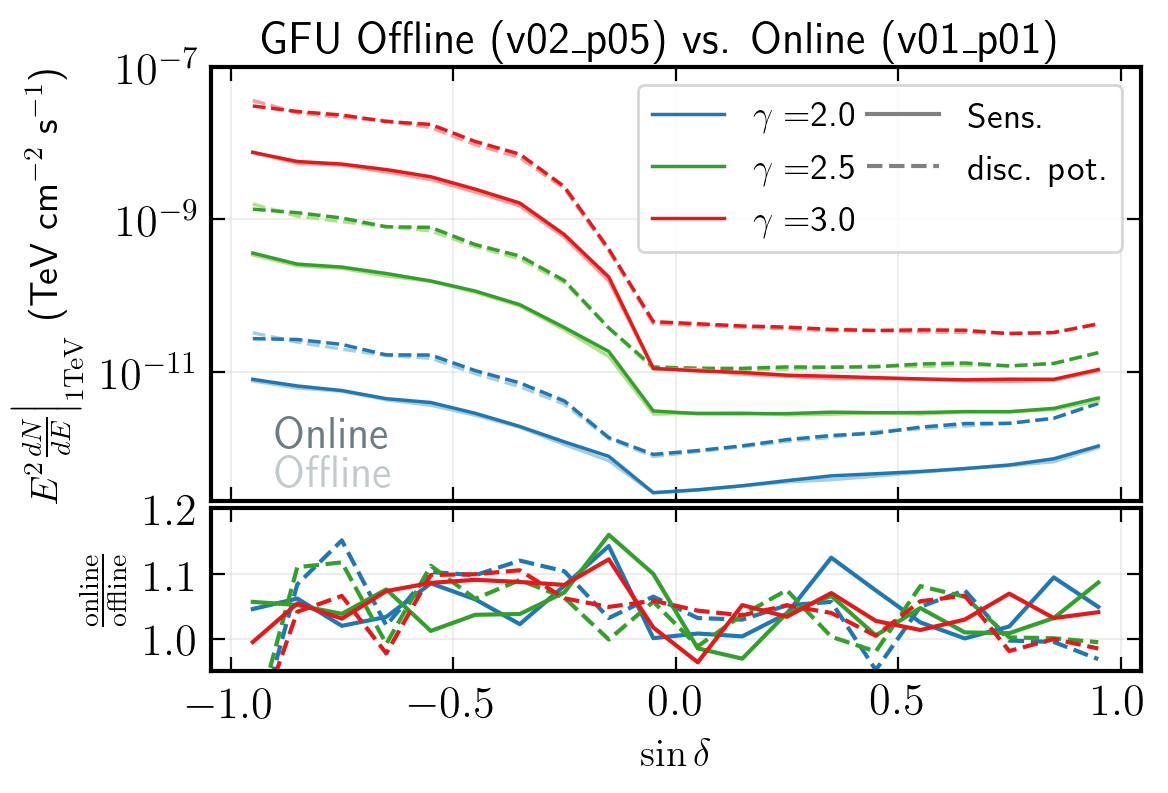

In [9]:
fig = plt.figure(dpi=200)
spec = mpl.gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[4, 1.5])
ax1 = fig.add_subplot(spec[1])
ax0 = fig.add_subplot(spec[0], sharex=ax1)
spec.update(wspace=0.025, hspace=0.025)
fig.set_facecolor('w')

for ii, gamma in enumerate(inj_gamma):
    one_tev_sens = conv_ref_en(all_gamma_results[gamma]['sens_e2dnde'], 1., 100., gamma)
    one_tev_disc = conv_ref_en(all_gamma_results[gamma]['disc_e2dnde'], 1., 100., gamma)
    ax0.plot(all_gamma_results[gamma]['sindec'], one_tev_sens,
            color=palette[2*ii], lw=1.25, ls='-')
    ax0.plot(all_gamma_results[gamma]['sindec'], one_tev_disc,
            color=palette[2*ii], lw=1.25, ls='--')
    
    one_tev_sens_online = conv_ref_en(all_gamma_results_online[gamma]['sens_e2dnde'], 1., 100., gamma)
    one_tev_disc_online = conv_ref_en(all_gamma_results_online[gamma]['disc_e2dnde'], 1., 100., gamma)
    ax0.plot(all_gamma_results_online[gamma]['sindec'], one_tev_sens_online,
            color=palette[2*ii+1], lw=1.25, ls='-', label=r'$\gamma=$' +f'{gamma}')
    ax0.plot(all_gamma_results_online[gamma]['sindec'], one_tev_disc_online,
            color=palette[2*ii+1], lw=1.25, ls='--')
    
    ax1.plot(all_gamma_results_online[gamma]['sindec'], one_tev_sens_online / one_tev_sens,
            color=palette[2*ii+1], lw=1.5, ls='-')
    ax1.plot(all_gamma_results_online[gamma]['sindec'], one_tev_disc_online / one_tev_disc,
            color=palette[2*ii+1], lw=1.5, ls='--')
    
handles, labels = ax0.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', lw=1.5, linestyle='-', label='Sens.')
handles.append(patch) 
patch = Line2D([0], [0], color='grey', lw=1.5, linestyle='--', label='disc. pot.')
handles.append(patch) 
    
ax0.legend(loc=1, frameon=True, ncol=2, handles=handles, fontsize=13, columnspacing=0.3)
ax0.set_yscale('log')
ax0.set_ylim(2e-13, 1e-7)
ax0.text(-0.9, 1e-12, 'Online', color=sns.xkcd_rgb['battleship grey'])
ax0.text(-0.9, 3e-13, 'Offline', color=sns.xkcd_rgb['battleship grey'], alpha=0.4)
ax1.set_ylim(0.95, 1.2)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.set_ylabel(r'$E^2\frac{dN}{dE}\bigg|_{\mathrm{1 TeV}}$ (TeV cm$^{-2}$ s$^{-1}$)', fontsize=14)
ax1.set_xlabel(r'$\sin \delta$', fontsize=14)
ax1.set_ylabel(r'$\frac{\mathrm{online}}{\mathrm{offline}}$', fontsize=14)
fig.suptitle("GFU Offline (v02\_p05) vs. Online (v01\_p01)", fontsize=16, y=0.94)
#plt.tight_layout()
for stype in ['pdf', 'png']:
    plt.savefig(f'./dump/time_integrated_online_vs_offline_comparison.{stype}', dpi=200,
               bbox_inches='tight')
plt.show()